# __ACA dark current map - simulations__

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import numpy.ma as ma
import collections
from Ska.Matplotlib import plot_cxctime

In [2]:
#   For each image, pick out the 'X's
#
#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  XXXXXXXX  |        X....X
#   |/ XX....XX  |/       X....X
#      XX....XX           X....X
#      XX....XX           X....X
#      XX....XX           .XXXX.
#      XXXXXXXX
#      XXXXXXXX
#      (2)--->

#r = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
#     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
#     2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]
#c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
#     0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
#     0, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 6, 7, 7, 7, 7]
#

# OR
#
#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  X......X  |        X....X
#   |/ X......X  |/       X....X
#      X......X           X....X
#      X......X           X....X
#      X......X           .XXXX.
#      X......X
#      XXXXXXXX
#      (2)--->

### Simulate telemetry in <code>aca_l0</code> format ###

In [3]:
# 2-d Gaussian star with magnitude mag and FWHM, noise: gaussian
def simulate_star(fwhm, mag, integ, bgd=None, roff=0, coff=0):
    
    img_size = 8
    img_size2 = img_size * img_size
        
    if np.shape(bgd) not in [(), (img_size, img_size), (img_size2,)]:
        raise Exception('bgd expected to be int, float or (8, 8) or (64,) array')
    
    star = np.zeros((img_size, img_size))

    # Mag to counts conversion
    gain = 5. # e-/ADU
    counts = integ * transform.mag_to_count_rate(mag) / gain

    # Gaussian model
    halfsize = np.int(img_size / 2)
    row, col = np.mgrid[-halfsize:halfsize, -halfsize:halfsize] + 0.5
    sigma = fwhm / (2. * np.sqrt(2. * np.log(2.)))
    g = np.exp(-((row - roff)**2  / sigma**2 + (col - coff)**2 / sigma**2) / 2.)
    
    # Zero 6x6 corners
    g = zero_6x6_corners(g, centered=True)
    
    # Normalize to counts
    i1 = np.int(halfsize + 0.5 - 3)
    i2 = np.int(halfsize + 0.5 + 3)
    g = counts * g / g[i1:i2][i1:i2].sum()    

    # Simulate star
    star = np.random.normal(g)
        
    # Add background
    if bgd == 0:
        bgd = np.zeros((img_size, img_size))
    if np.shape(bgd) == () and bgd > 0:
        bgd = np.random.normal(bgd, np.sqrt(bgd), img_size2).reshape(img_size, img_size)
    if np.shape(bgd) == img_size2:
        bgd = bgd.reshape(img_size, img_size)
        
    # bgd < 0 -> set equal to 0
    bgd = bgd * (bgd > 0)
    bgd = zero_6x6_corners(bgd, centered=True)
    
    star = star + bgd
    
    return np.rint(star)


def simulate_aca_l0(img_size, nframes, delta_t, integ, \
                    bgdavg=None, fwhm=1.8, mag=10.2, phase=0, roff=0, coff=0):

    t_end = nframes * delta_t - delta_t
    times = np.arange(0, t_end, delta_t) 

    # define dither to get imgrow0, imgcol0
    ampl = 8. * u.arcsec
    pxsize = 5. * u.arcsec # per pixel
    pitch_period = 707.1 # sec
    yaw_period = 1000.0 # sec
    delta_pitch = 0. # sec
    delta_yaw = delta_pitch + phase # sec

    pitch = ampl / pxsize * np.sin(2 * np.pi * times / pitch_period + delta_pitch) - 0.5 # col0
    yaw = ampl / pxsize * np.sin(2 * np.pi * times / yaw_period + delta_yaw) - 0.5 # row0

    col0 = np.rint(pitch)
    row0 = np.rint(yaw)

    data = []
    img_size2 = img_size * img_size
    
    for i, time in enumerate(times):
        imgraw = simulate_star(fwhm, mag, integ, bgdavg, roff=roff, coff=coff) # 8x8
        imgraw = imgraw.reshape(1, img_size2)[0]
        mask = img_size2 * [0]
        fill_value = 1.e20
        imgraw = ma.array(data=imgraw, mask=mask, fill_value=fill_value)
        
        data_row = (time, imgraw, row0[i], col0[i], bgdavg, img_size)
        data.append(data_row)
        
    data = np.ma.array(data, dtype=[('TIME', '>f8'), ('IMGRAW', '>f4', (64,)),
                                    ('IMGROW0', '>i2'), ('IMGCOL0', '>i2'),
                                    ('BGDAVG', '>i2'), ('IMGSIZE', '>i4')])

    return data

### Dark current map ###

In [4]:
# frame_data = current row in Table(slot_data)
def get_frame_row(frame_data, img_size, r, c):
    
    frame_row = collections.OrderedDict()
    
    row0 = frame_data['IMGROW0'][0]
    col0 = frame_data['IMGCOL0'][0]
    raw_image = frame_data['IMGRAW'][0]
    
    # Pick out the edge pixels
    frame_row['edge_vals'] = edge_pixels(img_size, raw_image, row0, col0, r, c)
        
    frame_row['row0'] = row0
    frame_row['col0'] = col0
    frame_row['raw_img'] = raw_image
    frame_row['bgdavg'] = frame_data['BGDAVG'][0]
    frame_row['time'] = frame_data['TIME'][0]

    return frame_row


def edge_pixels(img_size, raw_image, row0, col0, r, c):

    edge_pixels = collections.OrderedDict()
    
    raw_image = raw_image.reshape(img_size, img_size) # order!
    
    for rr, cc in zip(r, c): # (r, c) define location of edge pixels (X's)
        r_abs = row0 + rr + shift
        c_abs = col0 + cc + shift
        key = (r_abs, c_abs) # e.g. (781, 428), a tuple
        edge_pixels[key] = raw_image[rr, cc]
        
    return edge_pixels


def update_deque_dict(deque_dict, frame_row, r, c):
    # Update deque_dict:
    # 1. Compute current coordinates of the edge pixels (0:1023)
    # 2. extend or init deque with edge value if we are on the edge
    # 3. if > ndeque elements in a deque, pop the first one
    
    # current edge row/col coords in 0:1023
    r_current_edge = r + (frame_row['row0'] + shift) * np.ones(len(r))
    c_current_edge = c + (frame_row['col0'] + shift) * np.ones(len(c))
    
    for (rr, cc) in zip(r_current_edge, c_current_edge):
        if (rr, cc) in deque_dict.keys():    
            deque_dict[(rr, cc)].extend([frame_row['edge_vals'][(rr, cc)]])                
            # record time, negative coords as keys
            deque_dict[(-rr, -cc)].extend([frame_row['time']])              
            # Keep the length at ndeque
            if len(deque_dict[(rr, cc)]) > ndeque:
                deque_dict[(rr, cc)].pop()
        else: # initialize
            deque_dict[(rr, cc)] = collections.deque([frame_row['edge_vals'][(rr, cc)]])                   
            deque_dict[(-rr, -cc)] = collections.deque([frame_row['time']])                   
            
    return deque_dict


def dark_current_background(frame_row, img_size, deque_dict, bgd='mixed'):

    row0 = frame_row['row0']
    col0 = frame_row['col0']
    bgdavg = frame_row['bgdavg']

    bgd_img = np.zeros((img_size, img_size))
    
    for rr in range(8):
        for cc in range(8):
            key = (rr + row0 + shift, cc + col0 + shift)
            if key in deque_dict.keys():
                bgd_img[rr, cc] = np.median(deque_dict[key])
            else:
                if bgd == 'mixed':
                    bgd_img[rr, cc] = bgdavg

    return bgd_img


# img_size = 6 science observation
# img_size = 8 ER observation
# img_mask = None for science observations
def get_current_centroids(img, img_size):
    
    num = np.arange(0.5, 6.5)

    #How relevant is this?
    if (img_size == 8):
        img = zero_6x6_corners(img, centered=True)
    else:
        img = zero_6x6_corners(img, centered=False)
    
    centroids = []
    for ax in [1, 0]:
        # Def of flat is where img_mask becomes relevant for ER data and telemetry comparison
        flat = np.sum(img, axis=ax)
        if (img_size == 6):            
            centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2]) # 0:6
        else:
            # 1:7, is +1 relevant? yes, if row0/col0 always the lower left pixel in 8x8
            centroid = np.sum(flat[1:-1] * num) / np.sum(flat[1:-1]) + 1 # 1:7
        centroids.append(centroid)
        
    return centroids # [row, col]


def zero_6x6_corners(img, centered=True): # img is a 8x8 array
    if not img.shape == (8, 8):
        raise Exception("Img should be a 8x8 array")
    if centered:
        r4 = [1, 1, 6, 6]
        c4 = [1, 6, 1, 6]
    else:
        r4 = [0, 0, 5, 5]
        c4 = [0, 5, 0, 5]
    for rr, cc in zip(r4, c4):
        img[rr][cc] = 0.0
    return img

### Centroids ###

In [5]:
def centroids(slots, img_size, bgd='mixed', sim=False, **kwargs):
    # Calls:
    #     simulate_aca_l0
    #     get_centroids
   
    rows = []

    for slot in slots:
        print 'Slot = {}'.format(slot)
        slot_row = {'slot':slot, 'row0':[], 'col0':[],
                    'yan_raw':[], 'zan_raw':[], 'row':[], 'col':[]}
        
        # Simulate slot_data in aca_l0 format, or read aca_l0 slot data
        if sim:
            if all(x in kwargs.keys() for x in ['nframes', 'delta_t', 'integ', 'bgdavg']):
                slot_data = simulate_aca_l0(img_size, **kwargs)
            else:
                raise Exception('centroids:: Not enough parameters to simulate aca_l0 data')
        else:
            slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        
        rowcol_cntrds, yagzag_cntrds, bgd_pixel_series = get_centroids(slot_data, img_size, bgd=bgd)

        slot_data = Table(slot_data)
        
        slot_row['time'] = slot_data['TIME']
        slot_row['row0'] = slot_data['IMGROW0']
        slot_row['col0'] = slot_data['IMGCOL0']
        
        raw_yagzag = np.array(yagzag_cntrds).T # [0] - yag, [1] - zag
    
        slot_row['yan_raw'].append(raw_yagzag[0])
        slot_row['zan_raw'].append(raw_yagzag[1])

        raw_rowcol = np.array(rowcol_cntrds).T # [0] - row, [1] - col
    
        slot_row['row'].append(raw_rowcol[0])
        slot_row['col'].append(raw_rowcol[1])
        
        slot_row['bgd_px_series'] = bgd_pixel_series
        
        rows.append(slot_row)
    
    return rows


def get_centroids(slot_data, img_size, bgd='mixed'):
    # For each frame:
    # 1. Reorganize slot_data[index] into a frame_row (contains e.g. edge_pixels)
    # 2. Compute and subtract background image
    #     a. Update deque_dict
    #     b. Compute bgd_img, algorithm depends on 'bgd' argument
    #         - 'bgdavg': avg background (current algorithm)
    #         - 'dark_current': median for sampled pixels, zero for not sampled pixels
    #         - 'mixed': median for sampled pixels, avg bgd for not sampled pixels
    # 3. Compute centroids (rowcol)
    # 4. Transform to get yagzag coordinates
    #
    # Calls:
    #     get_frame_row
    #     update_deque_dict
    #     dark_current_background
    #     get_current_centroids
    #
    
    if bgd not in ['bgdavg', 'dark_current', 'mixed']:
        raise Exception("get_centroids:: unrecognized bgd type, use: bgdavg, dark_current, or mixed")
        
    if img_size not in [6, 8]:
        raise Exception('get_centroids:: expected img_size = 6 or 8')
        
    if img_size == 8:
        r = [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]
        c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]
        img_mask = get_mask_8x8_centered()
    else:
        r = [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 1, 2, 3, 4, 1, 2, 3, 4]
        c = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 5, 5, 5, 5]
        img_mask = None
    
    nn = len(slot_data)
    
    deque_dict = collections.OrderedDict()
    
    yagzag_centroids = []
    rowcol_centroids = []

    for index in range(0, nn):
        
        frame_data = slot_data[index:index + 1]
        frame_row = get_frame_row(frame_data, img_size, r, c)
        
        if bgd in ['dark_current', 'mixed']:
            deque_dict = update_deque_dict(deque_dict, frame_row, r, c)
            bgd_img = dark_current_background(frame_row, img_size, deque_dict, bgd=bgd)
        else:
            bgd_img = frame_row['bgdavg'] * np.ones((img_size, img_size))
            
        raw_img = frame_row['raw_img']
        raw_img = raw_img.reshape(img_size, img_size)
        
        img = raw_img - bgd_img

        # For dark_current, don't oversubtract? px with bgd > raw val will be set to zero
        if bgd in ['dark_current', 'mixed']:
            bgd_mask = bgd_img > raw_img
            img = raw_img - ma.array(bgd_img, mask=bgd_mask)
            img = img.data * ~bgd_mask

        if img_mask is not None:
            img = ma.array(img, mask=img_mask) # mask before computing centroids
                        
        # Calculate centroids for current bgd subtracted img, use first moments
        rowcol = get_current_centroids(img, img_size)
        rowcol_centroids.append(rowcol)

        # Translate (row, column) centroid to (yag, zag)
        y_pixel = rowcol[0] + frame_row['row0'] # do not add shift
        z_pixel = rowcol[1] + frame_row['col0']            
        yagzag = transform.pixels_to_yagzag(y_pixel, z_pixel)

        yagzag_centroids.append(yagzag)
                                   
    return rowcol_centroids, yagzag_centroids, deque_dict


# In 8x8 img, mask the edge pixels, leave r/c 1:7 unmasked.
# For science observations the raw image is masked by default (r/c 0:6 are left unmasked).
def get_mask_8x8_centered():
    m = """\
        1 1 1 1 1 1 1 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1"""
    mask = np.array([line.split() for line in m.splitlines()], dtype=float)
    return mask

In [6]:
# Plotting functions

def plot_d_ang(key, dt, t):
    # plot delta yan(or zan)
    ylim = [(76, 82), (2272, 2278)]
    fig = plt.figure(figsize=(10, 20))
    
    for i, slot in enumerate([4, 7]):
        plt.subplot(4, 2, i + 1)
        ang_interp = Ska.Numpy.interpolate(t[key][slot][0], t['time'][slot] + dt[i],
                                           t['time'][2],
                                           method="nearest")
        d_ang = t[key][2][0] - ang_interp
        plt.plot(t['time'][2], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.ylim(ylim[i])
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.title('Slot 2 - Slot {}'.format(slot))
        plt.legend()

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return

### Computations ###

In [7]:
#slots = range(8)
slots = [0]
shift = 512 # so that we end up with coordinates in the 0:1023 range
ndeque = 1000 # number of vals in deque before we start to pop()

In [8]:
img_size = 8 # pixels
nframes = 1000
delta_t = 4.1 # sec
integ = 1.696 # sec
bgdavg = 10. # pixel value
kwargs = {'nframes':nframes, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg}

__Simulate a 10.2 mag (default value) centered in the 8x8 image, with constant background (bgdavg):__

In [9]:
bgd = 'bgdavg'
rows_ba = centroids(slots, img_size, bgd=bgd, sim=True, **kwargs) # bgd_px_series will be empty

Slot = 0


In [10]:
bgd = 'mixed'
rows_m = centroids(slots, img_size, bgd=bgd, sim=True, **kwargs)

Slot = 0


In [11]:
t_ba = Table(rows_ba)

In [12]:
t_m = Table(rows_m)

In [13]:
print t_m.colnames

['bgd_px_series', 'col', 'col0', 'row', 'row0', 'slot', 'time', 'yan_raw', 'zan_raw']


In [14]:
print t_m['time', 'row', 'yan_raw']
print len(t_m['time'][0])
print len(t_m['row'][0][0])

 time [1000]           row [1,1000]                 yan_raw [1,1000]       
------------- ------------------------------ ------------------------------
0.0 .. 4095.9 4.01051051051 .. 3.99698795181 10.3644126309 .. 10.4131801386
1000
1000


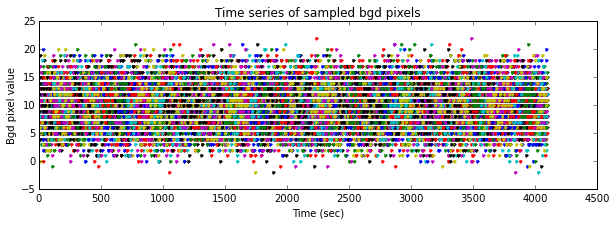

In [31]:
keys =  t_m[0]['bgd_px_series'].keys()

fig = plt.figure(figsize=(10, 3))

for i, key in enumerate(keys):
    if i % 2 == 0:
        key_time = (-key[0], -key[1])
        plt.plot(t_m[0]['bgd_px_series'][key_time], t_m[0]['bgd_px_series'][key], '.')
    plt.title("Time series of sampled bgd pixels")
    plt.xlabel('Time (sec)')
    plt.ylabel('Bgd pixel value')

4.00
4.00


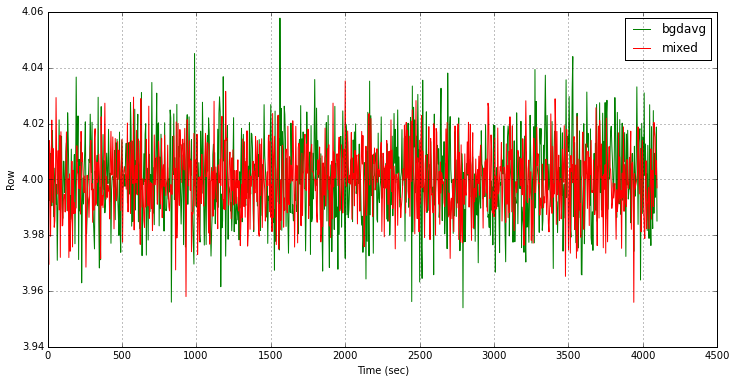

In [30]:
fig = plt.figure(figsize=(12, 6))
color = ['green', 'red']
method = ['bgdavg', 'mixed']
for i, t in enumerate([t_ba, t_m]):
    print '{:.2f}'.format(np.median(t['row'][0][0]))
    plt.plot(t['time'][0], t['row'][0][0], color=color[i], label=method[i])
plt.ylabel("Row")
plt.xlabel("Time (sec)")
plt.grid()
plt.legend()

__Repeat but with 1px row offset:__

In [17]:
# Simulate star with 1px offset in row number
kwargs['roff'] = 1
bgd = 'mixed'
rows_m_roff = centroids(slots, img_size, bgd=bgd, sim=True, **kwargs)

Slot = 0


In [18]:
t_m_roff = Table(rows_m_roff)

4.00
4.97


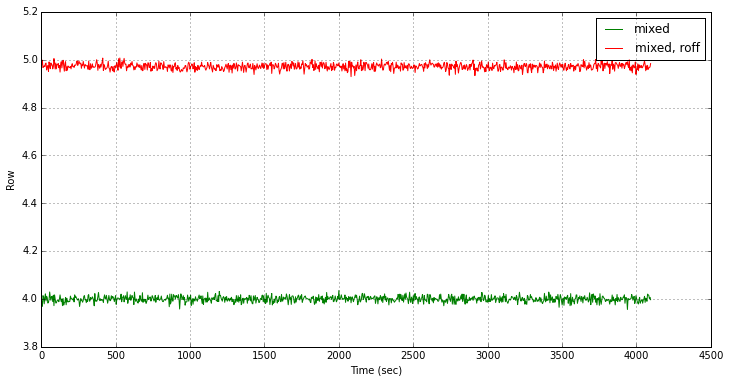

In [29]:
fig = plt.figure(figsize=(12, 6))
color = ['green', 'red']
method = ['mixed', 'mixed, roff']
for i, t in enumerate([t_m, t_m_roff]):
    print '{:.2f}'.format(np.median(t['row'][0][0]))
    plt.plot(t['time'][0], t['row'][0][0], color=color[i], label=method[i])
plt.ylabel("Row")
plt.xlabel("Time (sec)")
plt.grid()
plt.legend()

__Perform computations for real data__

In [20]:
# 50804, stars in all slots tracked, star in slot 7 faint, all other stars bright
obsid = 50804
dwell = events.dwells.filter(obsid=obsid)[0]
slots = range(8)

In [21]:
bgd = 'bgdavg'
rows_data_ba = centroids(slots, img_size, bgd=bgd, sim=False)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [22]:
bgd = 'mixed'
rows_data_m = centroids(slots, img_size, bgd=bgd, sim=False)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [23]:
t_data_ba = Table(rows_data_ba)
t_data_m = Table(rows_data_m)

Method: average background subtraction


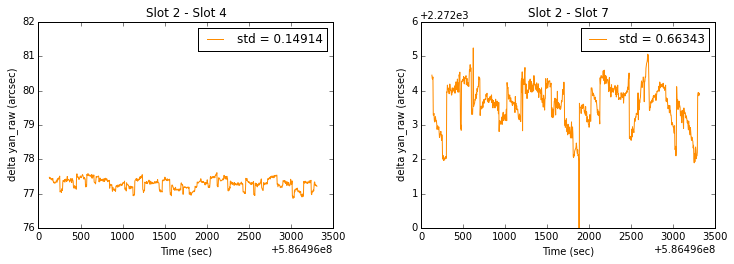

In [24]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_data_ba)
print "Method: average background subtraction"

Method: mixed background


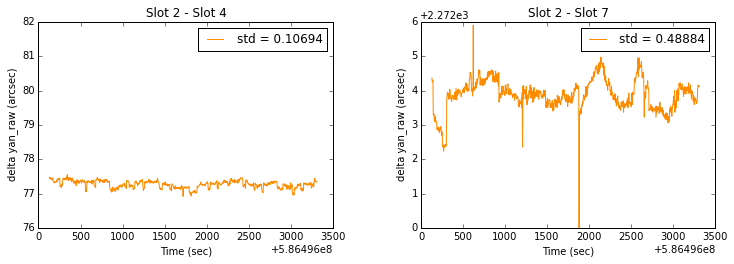

In [25]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_data_m)
print "Method: mixed background"

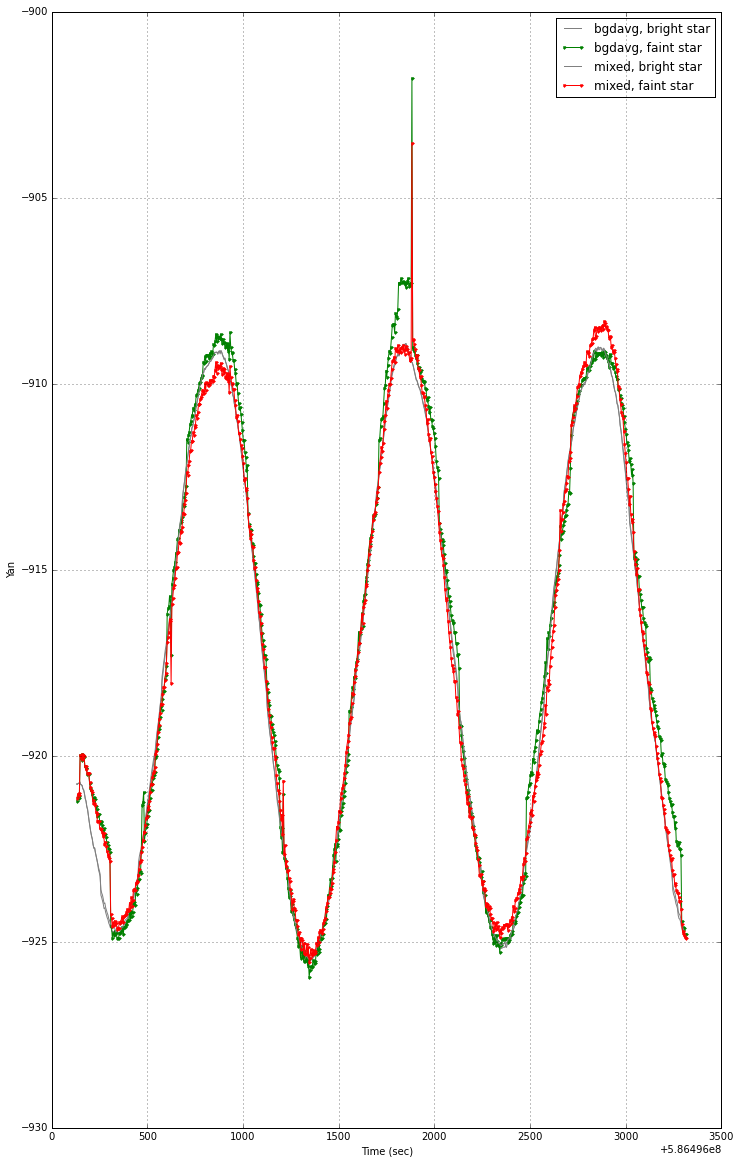

In [28]:
fig = plt.figure(figsize=(12, 20))
color = ['green', 'red']
method = ['bgdavg', 'mixed']
for i, t in enumerate([t_data_ba, t_data_m]):
    plt.plot(t['time'][2], t['yan_raw'][2][0] - 2276, color='gray',
             label=method[i] +', bright star')
    plt.plot(t['time'][7], t['yan_raw'][7][0], color=color[i], marker='.',
             label=method[i] +', faint star')
plt.ylabel("Yan")
plt.xlabel("Time (sec)")
plt.grid()
plt.legend()